In [1]:
import json
import pandas as pd
import numpy as np
from utils.globals import *
from utils.prompt_utils import AmbigousARCDataset
from utils.plot_utils import plot_item
from utils.eval import Eval, ModelEval
from utils.globals import *
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm import tqdm
import requests
import os
X_API_KEY = 'sk-np-IChhuM0WWR6P59VLwzoj2CI4jrnrpMp4IAPnCUGzl4Y0'
mpl.rcParams['figure.dpi'] = 300

from IPython.display import IFrame

def get_dashboard_html(sae_release = "gemma-2-2b", sae_id="20-gemmascope-res-16k", feature_idx=0):
    html_template = "https://neuronpedia.org/{}/{}/{}?embed=true&embedexplanation=true&embedplots=true&embedtest=true&height=300"
    return html_template.format(sae_release, sae_id, feature_idx)

In [2]:
def calculate_percentiles(frequencies):
    return (np.cumsum(frequencies) / np.sum(frequencies)) * 100

def get_activation_percentile(act_values, percentiles, new_act, interpolate=False):
    if new_act < act_values[0]:
        print("New value is below the minimum value in the dataset.")
        return 0
    elif new_act > act_values[-1]:
        print("New value is above the maximum value in the dataset.")
        return 100
    
    # Find the two closest values where the new value act between
    lower_index = np.searchsorted(act_values, new_act) - 1
    upper_index = lower_index + 1
    
    # Get the corresponding values and percentiles
    lower_value = act_values[lower_index]
    lower_percentile = percentiles[lower_index]
    
    if interpolate:
        upper_value = act_values[upper_index]
        upper_percentile = percentiles[upper_index]
        return lower_percentile + (new_act - lower_value) / (upper_value - lower_value) * (upper_percentile - lower_percentile)
    
    return lower_percentile

def interpolate_percentile_to_value(percentile, percentiles, values):
    """
    Convert a given percentile into the associated value using interpolation from
    an existing list of percentiles and values.
    
    Args:
    percentile (float): The percentile (between 0 and 1) for which to find the associated value.
    percentiles (list or numpy array): List of percentiles (between 0 and 1).
    values (list or numpy array): List of corresponding values for the percentiles.
    
    Returns:
    float: The interpolated value associated with the given percentile.
    """
    # Ensure inputs are numpy arrays
    percentiles = np.array(percentiles)
    values = np.array(values)
    
    # Check if the percentile is within the range of the given percentiles
    if percentile < percentiles[0] or percentile > percentiles[-1]:
        raise ValueError("Percentile is out of range.")
    
    # Use np.interp to perform linear interpolation
    return np.interp(percentile, percentiles, values)

def get_feature_data(model_id, sae_id, feat_idx):
    url = f"https://www.neuronpedia.org/api/feature/{model_id}/{sae_id}/{feat_idx}"
    headers = {"X-Api-Key": X_API_KEY}
    response = requests.get(url, headers=headers)
    if response.status_code == 200:
        return response.json()
    else:
        raise Exception(f"Failed to get feature data. Status code: {response.status_code}")
    
def get_activation_percentile_for_feature(model_id, sae_id, feat_idx, new_act, interpolate=False):
    feature_data = get_feature_data(model_id, sae_id, feat_idx)
    act_values = feature_data['freq_hist_data_bar_values']
    frequencies = feature_data['freq_hist_data_bar_heights']
    percentiles = calculate_percentiles(frequencies)
    return get_activation_percentile(act_values, percentiles, new_act, interpolate)

In [23]:
def calculate_precision(acts, labels, concept):
    # Boolean mask for items in the concept
    concept_mask = (np.array(labels) == concept)  
    # Collapse the token dimension (any activation across tokens)
    feature_activation = np.any(acts > 0, axis=1)  # shape: (items, features)
    # Calculate A_c(f) for the concept (proportion of items in concept with feature activated)
    A_c = np.mean(feature_activation[concept_mask], axis=0)  # shape: (features,)
    # Calculate A_global(f) for all items (proportion of all items with feature activated)
    A_global = np.mean(feature_activation, axis=0)  # shape: (features,)
    # Calculate Precision as A_c(f) / A_global(f)
    precision = np.divide(A_c, A_global, out=np.zeros_like(A_c), where=A_global != 0)   # Use np.divide with where to avoid division by zero
    return precision, A_c, A_global

def mean_non_zero_activation_per_item(acts):
    # Mask to ignore both NaN and zero values
    non_zero_mask = (acts > 0) & ~np.isnan(acts)
    
    # Calculate the sum of non-zero values along the token dimension for each item-feature
    non_zero_sum = np.nansum(acts * non_zero_mask, axis=1)  # Sum of non-zero activations per item-feature (shape: items x features)
    
    # Calculate the count of non-zero activations per item-feature pair
    non_zero_count = np.sum(non_zero_mask, axis=1)  # Count of non-zero activations per item-feature (shape: items x features)
    
    # Calculate the mean of non-zero activations, setting it to 0 if there are no non-zero activations
    mean_non_zero = np.divide(non_zero_sum, non_zero_count, out=np.zeros_like(non_zero_sum), where=non_zero_count != 0)
    
    return mean_non_zero

def activation_specificity(acts, labels, concept):
    # Boolean mask for items in the concept
    concept_mask = (np.array(labels) == concept)  
    
    # Collapse the token dimension (average activation across tokens)
    feature_activation = np.nanmean(acts, axis=1)  # shape: (items, features)
    
    # Calculate A_c(f) for the concept (average activation for items in the concept)
    # Avoid masking with NaNs, just keep the active activations and calculate mean
    concept_activations = feature_activation[concept_mask]
    A_c = np.mean(concept_activations, axis=0)  # shape: (features,)
    
    # Calculate A_global(f) for all items (average activation across all items)
    A_global = np.mean(feature_activation, axis=0)  # shape: (features,)
    
    # Make sure to exclude features where A_global is zero (no activation at all globally)
    specificity = np.divide(A_c, A_global, out=np.zeros_like(A_c), where=A_global != 0)  # Handle division by zero
    
    return specificity, A_c, A_global

class SAEval:
    def __init__(self, sae_file, completion_file):
        self.acts = np.load(sae_file)['arr_0']
        #self.behavioral = Eval(completion_file, prop_test_thresh=None, no_response_thresh=None)
        self.behavioral = completion_file
        self.model_id = sae_file.split('/')[-2]
        self.layer = sae_file.split('_')[-1].split('.')[0]
        self.width = sae_file.split('-')[-1].split('_')[0]
        self.sae_id = f"{self.layer}-gemmascope-res-{self.width}"
        
        self.precision = {}
        for concept in set(self.behavioral.dataset.concepts):
            self.precision[concept] = calculate_precision(self.acts, self.behavioral.dataset.concepts, concept)

        self.specificity = {}
        for concept in set(self.behavioral.dataset.concepts):
            self.specificity[concept] = activation_specificity(self.acts, self.behavioral.dataset.concepts, concept)
    
    def get_sae_csv(self):
        url = "https://www.neuronpedia.org/api/explanation/export"
        querystring = {"modelId":self.model_id,"saeId":self.sae_id}
        headers = {"X-Api-Key": X_API_KEY}
        response = requests.get(url, headers=headers, params=querystring)
        df = pd.DataFrame(response.json()).rename(columns={'index': 'featureID'})
        df['featureID'] = df['featureID'].astype(int)
        return df.sort_values('featureID').reset_index(drop=True)
    
    def query(self, query, show_descriptions=True):
        '''
        Returns the index of the rows that contain the query in the feature description
        '''
        indices = self.df[self.df['description'].apply(lambda x: query in x)]['featureID'].to_list()
        if show_descriptions:
            for idx in indices:
                print(idx, ':', self.df.loc[idx, 'description'])
        return indices
    
    def display_feature(self, feature_idx):
        html = get_dashboard_html(self.model_id, self.sae_id, feature_idx)
        return IFrame(html, width=1000, height=400)

results_dir = 'data/sae'
model = 'gemma-2-9b'

# sum_feats = []
# for sae_file in sorted(os.listdir(f'{results_dir}/{model}')):
#     if sae_file.endswith('.npz'):
#         sae = SAEval(f'{results_dir}/{model}/{sae_file}', f'{results_dir}/{model}/completions.json')
#         sum_feats.append(np.sum(np.any(sae.acts > 0, axis=1), axis=1))

In [24]:
config = json.load(open(f'{results_dir}/{model}/completions.json'))['data_config']
config['example_item'] = '101'
config['items_data'] = 'data/items_old_.json'
dataset = AmbigousARCDataset(**config)
results = json.load(open(f'{results_dir}/{model}/completions.json'))
results.pop('data_config')
Eval(results, dataset=dataset, prop_test_thresh=None, no_response_thresh=None).models[0].answer_props

45


{'a': 0.5111111111111111, 'b': 0.4, 'c': 0.08888888888888889}

In [7]:
len(dataset.concepts)

46

In [ ]:
dataset

In [7]:
config

{'task': 'discrimination',
 'example_item': None,
 'encoding': 'int',
 'random_mat': True,
 'concept_answer_n': None,
 'seed': 45,
 'batch_size': 1,
 'items_data': 'data/items_old_.json'}

In [19]:
config

{'task': 'discrimination',
 'example_item': 'example',
 'encoding': 'int',
 'random_mat': True,
 'concept_answer_n': None,
 'seed': 45,
 'batch_size': 1,
 'dataset': 'data/items_old_.json'}

In [1]:
sae_file = sorted(os.listdir(f'{results_dir}/{model}'))[-1]
sae = SAEval(f'{results_dir}/{model}/{sae_file}', Eval(results, dataset=dataset, prop_test_thresh=None, no_response_thresh=None))
sae.behavioral.print()

max_idx_per_token = np.argmax(sae.acts, axis=-1)
max_idx_per_token = max_idx_per_token[max_idx_per_token != 0] # remove 0s

indices, counts = np.unique(max_idx_per_token, return_counts=True)
indices, counts = indices[np.argsort(counts)[::-1]], np.sort(counts)[::-1]
mean_acts = np.nanmean(sae.acts[:, :, indices], axis=(0, 1))

NameError: name 'os' is not defined

In [19]:
sae.precision['extend_to_boundary']

(array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0.11111111, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]))

In [118]:
percentiles = []
for feat_idx in tqdm(indices):
    url = f"https://www.neuronpedia.org/api/feature/{sae.model_id}/{sae.sae_id}/{feat_idx}"
    try:
        data = get_feature_data(sae.model_id, sae.sae_id, feat_idx)
        act_values = data['freq_hist_data_bar_values']
        frequencies = data['freq_hist_data_bar_heights']
        percentiles.append(calculate_percentiles(frequencies))
    except:
        print(f"Failed to get feature data for feature {feat_idx}")
        break

100%|██████████| 38/38 [00:53<00:00,  1.40s/it]


In [26]:
df_max = pd.DataFrame({'featureID': indices, 
              'count': counts, 
              'prop_all_tokens': (counts / np.sum(counts)).round(2),
              'mean_act': mean_acts.astype(float).round(2),
})
df_max

,featureID,count,prop_all_tokens,mean_act
0,4009,7115,0.35,301.87
1,12029,2296,0.11,63.59
2,1268,2144,0.11,52.29
3,4648,1683,0.08,112.43
4,2993,1319,0.06,52.24
5,7495,1116,0.05,28.96
6,3341,585,0.03,11.51
7,11380,429,0.02,14.53
8,14610,407,0.02,22.42
9,13353,402,0.02,13.48


In [91]:
indices

array([ 4009, 12029,  1268,  4648,  2993,  7495,  3341, 11380, 14610,
       13353,  6930,  3221, 14056, 12549,  7479,  2886, 10928, 13231,
       14216,  4805, 12173, 12185,  1517, 12387,  6407,  6584,  3751,
       15998,  8831,  4018,  8448, 10698, 10782,  1081,  5932,  7335,
        7200, 10692])

In [27]:
np.nanmean(sae.acts[:, :, indices], axis=(0, 1))

array([301.87027  ,  63.587322 ,  52.292793 , 112.43218  ,  52.237587 ,
        28.96157  ,  11.511885 ,  14.534161 ,  22.424898 ,  13.48192  ,
         9.542363 ,  10.168554 ,   7.9110556,   3.1735933,   6.241786 ,
        39.564087 ,  24.749788 ,  35.042137 ,  54.754772 ,  14.40893  ,
         4.823186 ,   6.4607325,   5.3226275,  18.434242 ,   1.4325821,
        45.998795 ,  46.805054 ,   2.2358708,  13.007361 ,  11.731894 ,
         2.325722 ,  15.971192 ,   0.8097172,   2.0742261,  17.463501 ,
         1.9973787,   1.588861 ,  63.24365  ], dtype=float32)

In [22]:
sae.display_feature(412)

In [42]:
counts/len(max_idx_per_token)

array([3.49906560e-01, 1.12914331e-01, 1.05439166e-01, 8.27677781e-02,
       6.48667257e-02, 5.48834464e-02, 2.87695485e-02, 2.10976689e-02,
       2.00157372e-02, 1.97698436e-02, 1.24422150e-02, 1.12127471e-02,
       1.10652110e-02, 1.10652110e-02, 9.34395594e-03, 8.85216878e-03,
       8.85216878e-03, 8.26202420e-03, 6.63912659e-03, 6.63912659e-03,
       6.09816072e-03, 5.85226714e-03, 4.42608439e-03, 3.19661650e-03,
       3.19661650e-03, 2.36057834e-03, 2.31139963e-03, 2.26222091e-03,
       2.26222091e-03, 2.21304220e-03, 2.21304220e-03, 2.21304220e-03,
       2.21304220e-03, 2.21304220e-03, 1.03275302e-03, 1.03275302e-03,
       4.91787155e-05, 4.91787155e-05])

In [45]:
counts

array([7115, 2296, 2144, 1683, 1319, 1116,  585,  429,  407,  402,  253,
        228,  225,  225,  190,  180,  180,  168,  135,  135,  124,  119,
         90,   65,   65,   48,   47,   46,   46,   45,   45,   45,   45,
         45,   21,   21,    1,    1])

In [44]:
len(max_idx_per_token)

20334

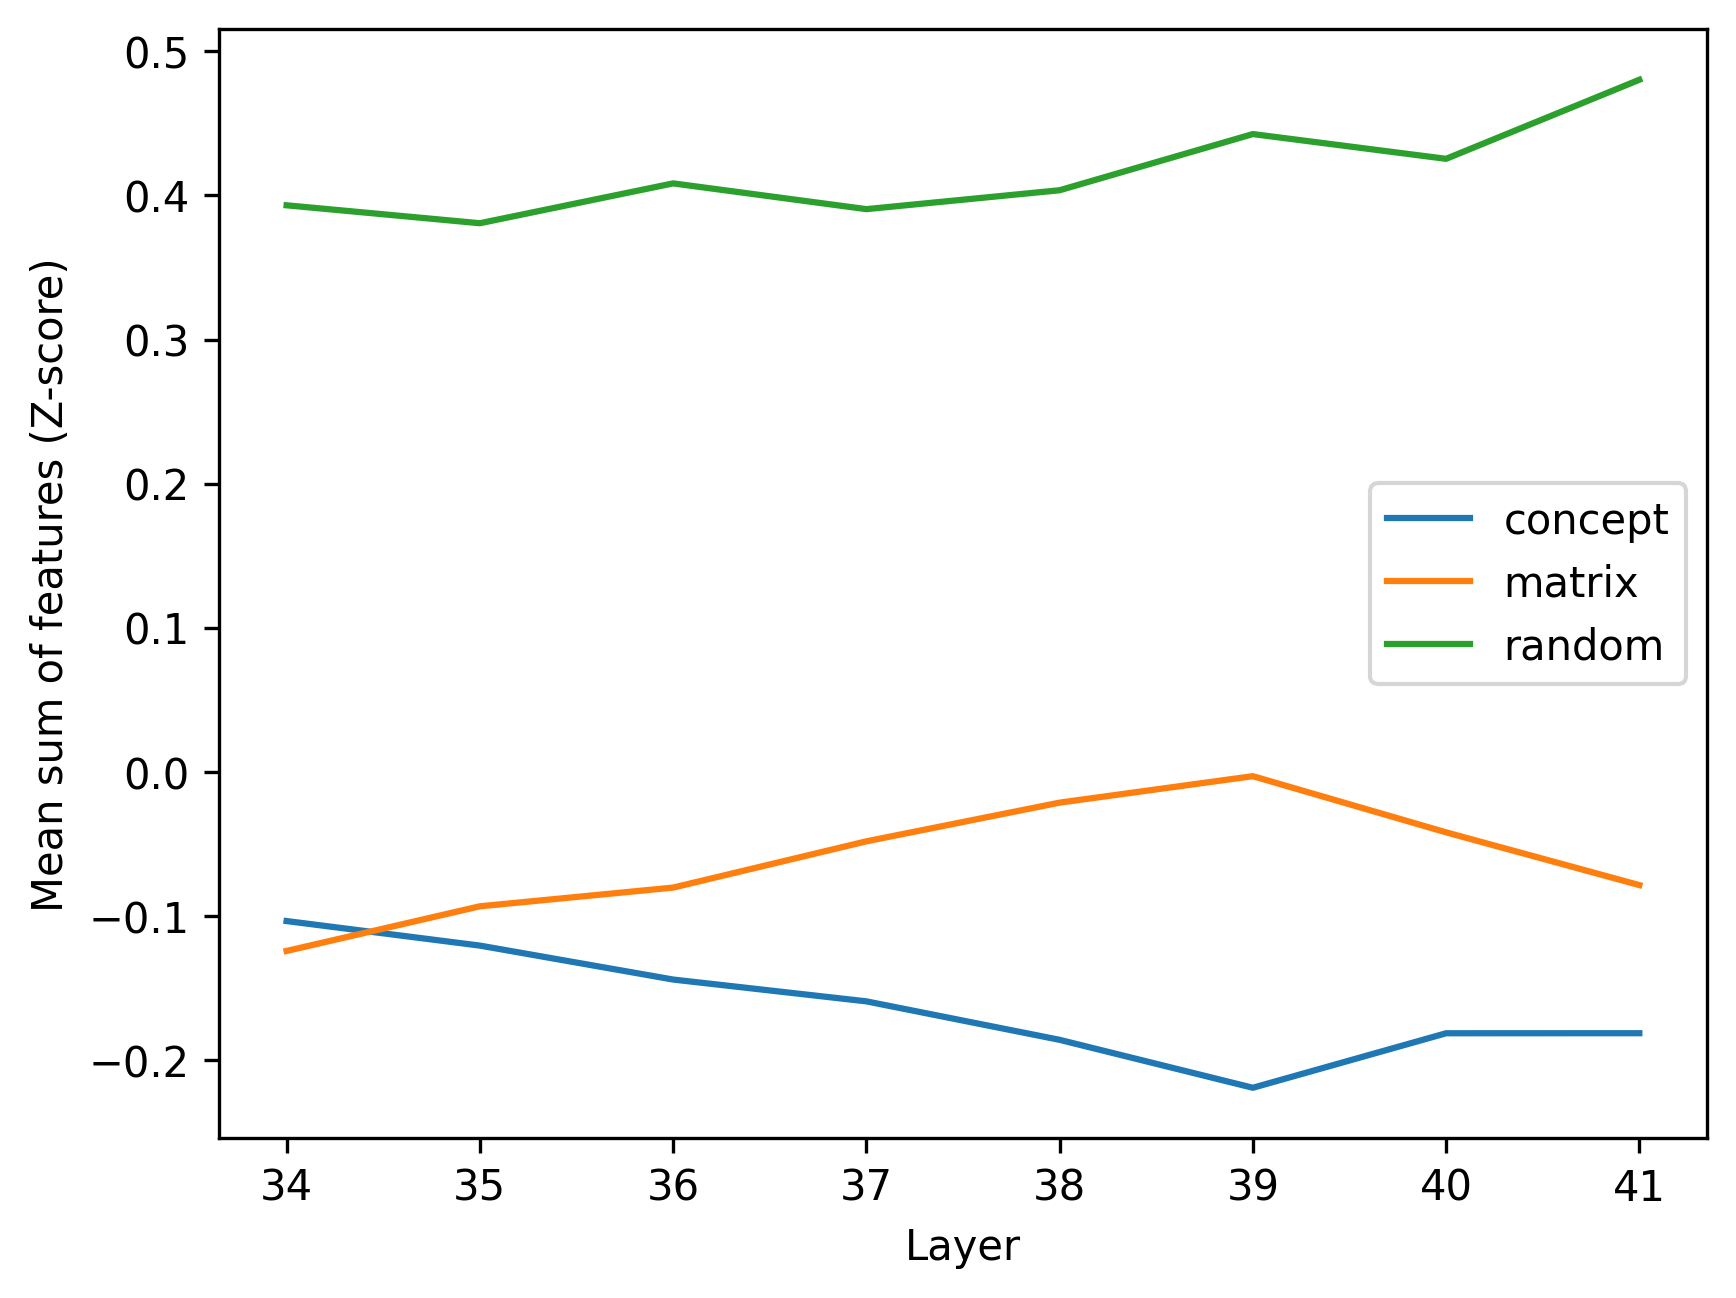

In [320]:
concept_sum_feats = []
matrix_sum_feats = []
random_sum_feats = []

for sum_feat in sum_feats:
    df = sae.behavioral.df
    df['sum_feats'] = sum_feat
    df['z_sum_feats'] = (df['sum_feats'] - df['sum_feats'].mean()) / df['sum_feats'].std()
    choices = df.groupby('choice')['z_sum_feats'].mean()
    concept_sum_feats.append(choices['concept'])
    matrix_sum_feats.append(choices['matrix'])
    random_sum_feats.append(choices['random'])

plt.plot(concept_sum_feats, label='concept')
plt.plot(matrix_sum_feats, label='matrix')
plt.plot(random_sum_feats, label='random')
plt.xlabel('Layer')
plt.ylabel('Mean sum of features (Z-score)')
plt.xticks(range(len(sum_feats)), range(34, 34 + len(sum_feats)))
plt.legend()
plt.show()

In [305]:
df.groupby('choice')['z_sum_feats'].mean()['concept']

-0.10344742145291592

In [321]:
import numpy as np

def entropy_per_item(activations):

    #activations = np.nanmean(activations, axis=1)  # shape: (items, features)
    # Normalize the activations by dividing each feature by the sum of activations for the item
    # Sum across the features (axis=-1) to ensure we get the total activation per item
    activation_sums = np.nansum(activations, axis=-1, keepdims=True)
    
    # Normalize the activations to get probabilities (ignoring NaNs)
    probabilities = np.divide(activations, activation_sums, where=activation_sums != 0)
    
    # Logarithm of the probabilities (ignoring zero activations)
    log_probs = np.where(probabilities > 0, np.log(probabilities), 0)
    
    # Compute entropy (sum over features for each item)
    entropy = -np.nansum(probabilities * log_probs, axis=-1)
    
    return entropy

e = entropy_per_item(sae.acts[:,-1,:])

/var/folders/9l/dl632xqj3d57xyzhdlhfn4x80000gn/T/ipykernel_16019/335632793.py:14: RuntimeWarning: divide by zero encountered in log
  log_probs = np.where(probabilities > 0, np.log(probabilities), 0)


In [243]:
avg_feats = np.nanmean(sae.acts, axis=1).mean(axis=1)
df = sae.behavioral.df
df['avg_feats'] = avg_feats
df.groupby('choice')['avg_feats'].mean()

choice
concept    0.300611
matrix     0.288411
random     0.288917
Name: avg_feats, dtype: float32

In [233]:
np.nanmean(sae.acts, axis=1).mean(axis=1)

array([0.1872706 , 0.18586002, 0.18662092, 0.18524812, 0.18640083,
       0.18326563, 0.18344888, 0.18795827, 0.187581  , 0.18725982,
       0.1850408 , 0.18433681, 0.18405436, 0.18615617, 0.18425073,
       0.18718621, 0.18734755, 0.18779281, 0.18769222, 0.17432633,
       0.17412838, 0.1800107 , 0.1725719 , 0.17838883, 0.17125604,
       0.1693097 , 0.17514077, 0.17675048, 0.16951604, 0.17431949,
       0.17488143, 0.17563182, 0.17116442, 0.17337462, 0.17122573,
       0.17315209, 0.17157918, 0.17906725, 0.17486593, 0.1742374 ,
       0.1744662 , 0.16971666, 0.1749995 , 0.17310664, 0.17352265],
      dtype=float32)

In [201]:
import numpy as np

def mean_non_zero_activation_per_item(acts):
    # Mask to ignore both NaN and zero values
    non_zero_mask = (acts > 0) & ~np.isnan(acts)
    
    # Calculate the sum of non-zero values along the token dimension for each item-feature
    non_zero_sum = np.nansum(acts * non_zero_mask, axis=1)  # Sum of non-zero activations per item-feature (shape: items x features)
    
    # Calculate the count of non-zero activations per item-feature pair
    non_zero_count = np.sum(non_zero_mask, axis=1)  # Count of non-zero activations per item-feature (shape: items x features)
    
    # Calculate the mean of non-zero activations, setting it to 0 if there are no non-zero activations
    mean_non_zero = np.divide(non_zero_sum, non_zero_count, out=np.zeros_like(non_zero_sum), where=non_zero_count != 0)
    
    return mean_non_zero

mean_non_zero_activation_per_item(sae.acts)


(45, 16384)

In [28]:
for concept, precision in sae.specificity.items():
    print(concept)
    print(precision[0].max())
    print(precision[1][precision[0].argmax()])
    print(precision[2][precision[0].argmax()])
    print(precision[0].argmax())

extend_to_boundary
11.250001
0.013066908
0.0011615029
3696
order
11.250001
0.006307059
0.00056062744
5296
clean_up
11.250001
0.012296708
0.0010930407
2724
horizontal_and_vertical
22.500002
0.012875192
0.0005722307
4146
top_and_bottom_3d
11.250001
0.013990343
0.001243586
156
inside_and_outside
22.500002
0.013398671
0.00059549644
3619
top_and_bottom_2d
11.250001
0.013210071
0.0011742285
723
filled_and_not_filled
11.250001
0.0068312036
0.00060721807
2108
copy
15.000001
0.008301989
0.0005534659
792
other
11.250001
0.0060580955
0.00053849735
2174
complete_shape
11.250001
0.0075157923
0.0006680704
537
move_to_boundary
22.5
0.013240842
0.0005884819
261
above_and_below
11.250001
0.006395659
0.000568503
7013


In [30]:
sae.display_feature(792)

In [148]:
sae.query(' clean')

[1583, 3057, 4676, 6823, 9050, 9769, 12598, 13956, 15658]

In [161]:
sae.df[sae.df['description'].apply(lambda x: ' clean' in x)]#['featureID']#.to_list()

,modelId,layer,featureID,description,explanationModelName,typeName
1583,gemma-2-9b,41-gemmascope-res-16k,1583,inquiries about maintenance and cleaning serv...,None,oai_token-act-pair
3057,gemma-2-9b,41-gemmascope-res-16k,3057,characteristics of tattoos and design elements...,None,oai_token-act-pair
4675,gemma-2-9b,41-gemmascope-res-16k,4676,references to cleaning and maintenance activities,None,oai_token-act-pair
6822,gemma-2-9b,41-gemmascope-res-16k,6823,terms related to methods or processes for clea...,None,oai_token-act-pair
9049,gemma-2-9b,41-gemmascope-res-16k,9050,mentions of cleanliness and cleaning actions,None,oai_token-act-pair
9768,gemma-2-9b,41-gemmascope-res-16k,9769,references to specific cleaning or maintenanc...,None,oai_token-act-pair
12597,gemma-2-9b,41-gemmascope-res-16k,12598,references to cleanliness and messiness in do...,None,oai_token-act-pair
13954,gemma-2-9b,41-gemmascope-res-16k,13956,references to cleaning and maintenance processes,None,oai_token-act-pair
15656,gemma-2-9b,41-gemmascope-res-16k,15658,terms related to environmental cleanup and con...,None,oai_token-act-pair


In [166]:
for concept, precision in sae.precision.items():
    print(concept)
    print(precision[0].max())
    print(precision[1][precision[0].argmax()])
    print(precision[2][precision[0].argmax()])
    print(precision[0].argmax())

top_and_bottom_3d
11.25
0.5
0.044444444444444446
69
top_and_bottom_2d
11.25
0.25
0.022222222222222223
655
complete_shape
11.25
0.25
0.022222222222222223
92
clean_up
11.25
0.25
0.022222222222222223
21
order
11.25
0.25
0.022222222222222223
108
horizontal_and_vertical
22.5
0.5
0.022222222222222223
30
above_and_below
11.25
0.25
0.022222222222222223
19
copy
14.999999999999998
0.3333333333333333
0.022222222222222223
412
inside_and_outside
22.5
0.5
0.022222222222222223
420
other
11.25
0.25
0.022222222222222223
7
extend_to_boundary
11.25
0.25
0.022222222222222223
353
move_to_boundary
22.5
0.5
0.022222222222222223
261
filled_and_not_filled
11.25
0.25
0.022222222222222223
1107


In [29]:
get_dashboard_html(sae.model_id, f"{sae.layer}-gemmascope-res-{sae.width}", 792)
IFrame(html, width=600, height=412)

NameError: name 'html' is not defined

In [324]:
sae.display_feature(792)

In [122]:
def get_dashboard_html(sae_release = "gemma-2-9b-it", sae_id="31-gemmascope-res-16k", feature_idx=0):
    html_template = "https://neuronpedia.org/{}/{}/{}?embed=true&embedexplanation=true&embedplots=true&embedtest=true&height=300"
    return html_template.format(sae_release, sae_id, feature_idx)

In [124]:
get_dashboard_html(

'https://neuronpedia.org/1000/31-gemmascope-res-16k/0?embed=true&embedexplanation=true&embedplots=true&embedtest=true&height=300'

In [109]:
sae.df[sae.df['description'].apply(lambda x: ' inside' in x)]

,modelId,layer,index,description,explanationModelName,typeName
15129,gemma-2-9b-it,31-gemmascope-res-16k,15131,instances of media citation or references to ...,gpt-4o-mini,oai_token-act-pair


In [90]:
d = sae.df

In [108]:
sae.query(' inside')

[15131]

In [68]:
concept_indices

[1583, 3057, 4676, 6823, 9050, 9769, 12598, 13956, 15658]

In [80]:
sae.df.iloc[4675]

modelId                                                        gemma-2-9b
layer                                               41-gemmascope-res-16k
index                                                                4676
description             references to cleaning and maintenance activities
explanationModelName                                                 None
typeName                                               oai_token-act-pair
Name: 4675, dtype: object

In [79]:
explanations_df.iloc[4675]

modelId                                                        gemma-2-9b
layer                                               41-gemmascope-res-16k
index                                                                4676
description             references to cleaning and maintenance activities
explanationModelName                                                 None
typeName                                               oai_token-act-pair
Name: 4675, dtype: object

In [64]:
concept_indices

[1583, 3057, 4676, 6823, 9050, 9769, 12598, 13956, 15658]

In [25]:
model_eval.models[0].answer_props

{'a': 0.6444444444444445, 'b': 0.24444444444444444, 'c': 0.1111111111111111}

In [27]:
model_eval.df.groupby('choice')['logprobs'].mean()

choice
concept    0.972633
matrix     0.893365
random     0.847266
Name: logprobs, dtype: float64

In [73]:
np.unique(np.argmax(sae, axis=-1)[0, :], return_counts=True)

(array([    0,  1081,  1268,  1517,  2886,  2993,  3221,  3341,  3751,
         4009,  4018,  4648,  4805,  6584,  7495,  8448,  8831, 10698,
        10782, 10928, 11380, 12029, 12185, 12387, 12549, 13231, 13353,
        14056, 14216, 14610, 15998]),
 array([204,   1,  19,   2,   4,  23,   5,  10,   1, 123,   1,  38,   3,
          1,  31,   1,   1,   1,   1,   4,   2,  30,   3,   1,   5,   4,
          4,   5,   3,   6,   1]))

In [75]:
# sort 
ind, count = np.unique(np.argmax(sae, axis=-1)[0, :], return_counts=True)

# get the top 10 most frequent classes
ind[np.argsort(count)[::-1]][:10]

array([4009])

In [136]:
inds = sae[9, -1, :].nonzero()[0]
acts = sae[9, -1, :][inds]
# sort
sort = np.argsort(acts)[::-1]
for i in range(15):
    print(inds[sort][i], acts[sort][i])

4009 190.1507
7335 133.61661
6407 119.069824
13546 116.4948
8448 103.848694
7200 96.26284
11658 88.39505
10928 85.87158
14216 81.68035
14294 78.234276
12387 70.8215
3731 66.62982
4805 56.798172
2924 56.069004
13352 54.470875


In [126]:
html

'https://neuronpedia.org/gemma-2-9b/41-gemmascope-res-16k/11808?embed=true&embedexplanation=true&embedplots=true&embedtest=true&height=300'

In [125]:
html = get_dashboard_html(sae_release = "gemma-2-9b", sae_id="41-gemmascope-res-16k", feature_idx=11808)
IFrame(html, width=600, height=600)

In [55]:
import requests
url = "https://www.neuronpedia.org/api/explanation/export"

querystring = {"modelId":"gemma-2-9b","saeId":"41-gemmascope-res-16k"}

headers = {"X-Api-Key": "sk-np-IChhuM0WWR6P59VLwzoj2CI4jrnrpMp4IAPnCUGzl4Y0"}

response = requests.get(url, headers=headers, params=querystring)

print(response.json())

[{'modelId': 'gemma-2-9b', 'layer': '41-gemmascope-res-16k', 'index': '13', 'description': 'quantities and measurements related to cooking ingredients', 'explanationModelName': None, 'typeName': 'oai_token-act-pair'}, {'modelId': 'gemma-2-9b', 'layer': '41-gemmascope-res-16k', 'index': '6', 'description': ' data relating to experimental observations and color-shape associations', 'explanationModelName': None, 'typeName': 'oai_token-act-pair'}, {'modelId': 'gemma-2-9b', 'layer': '41-gemmascope-res-16k', 'index': '86', 'description': 'references to golf courses and related activities', 'explanationModelName': None, 'typeName': 'oai_token-act-pair'}, {'modelId': 'gemma-2-9b', 'layer': '41-gemmascope-res-16k', 'index': '79', 'description': ' mathematical expressions and symbolic representations', 'explanationModelName': None, 'typeName': 'oai_token-act-pair'}, {'modelId': 'gemma-2-9b', 'layer': '41-gemmascope-res-16k', 'index': '30', 'description': 'chemical compounds or activities related

In [56]:
data = response.json()
explanations_df = pd.DataFrame(data)
explanations_df['index'] = explanations_df['index'].astype(int)
explanations_df = explanations_df.sort_values('index').reset_index(drop=True)

In [77]:
concept_indices = explanations_df[explanations_df['description'].apply(lambda x: ' clean' in x)]['index'].to_list()
concept_indices

[1583, 3057, 4676, 6823, 9050, 9769, 12598, 13956, 15658]

In [489]:
np.where((sae[:, :, concept_indices] > 0).sum(axis=1).sum(axis=1) > 0)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44]),)

In [490]:
(sae > 0).shape

(45, 538, 16384)

In [370]:
((sae[:, :, 9769] > 0).sum(axis=1) > 0)

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False,  True, False, False, False,
       False,  True, False, False, False, False, False, False, False])

In [387]:
np.any(sae > 0, axis=1).shape

(45, 16384)

In [425]:
9769

9769

In [507]:
Eval('/Users/gustaw/Downloads/completions.json', prop_test_thresh=None).dataset.concepts

Number of models: 1
Concept: 0.40
Matrix: 0.42
Random: 0.18

In [61]:
import numpy as np

def calculate_precision(data, labels, concept):
    # Collapse the token dimension (any activation across tokens)
    feature_activation = np.any(data > 0, axis=1)  # shape: (items, features)
    
    # Step 2: Find items that belong to the concept of interest
    concept_mask = (np.array(labels) == concept)  # Boolean mask for items in the concept
    
    # Step 3: Calculate A_c(f) for the concept (proportion of items in concept with feature activated)
    A_c = np.mean(feature_activation[concept_mask], axis=0)  # shape: (features,)
    
    # Step 4: Calculate A_global(f) for all items (proportion of all items with feature activated)
    A_global = np.mean(feature_activation, axis=0)  # shape: (features,)
    
    # Step 5: Calculate Precision as A_c(f) / A_global(f)
    # Use np.divide with where to avoid division by zero
    precision = np.divide(A_c, A_global, out=np.zeros_like(A_c), where=A_global != 0)
    
    return precision, A_c, A_global

p, ac_, a_glo = calculate_precision(sae.acts, Eval('/Users/gustaw/Downloads/completions.json', prop_test_thresh=None).dataset.concepts, 'clean_up')
p_sorted = np.argsort(p)[::-1][:1000]
for i in p_sorted:
    if ac_[i] > 0.1 :#and a_glo[i] < 0.1:
        print(i, p[i], ac_[i], a_glo[i])

7593 11.25 0.25 0.022222222222222223
3035 11.25 0.25 0.022222222222222223
3959 11.25 0.25 0.022222222222222223
8117 11.25 0.25 0.022222222222222223
14771 11.25 0.25 0.022222222222222223
8890 11.25 0.25 0.022222222222222223
1285 11.25 0.25 0.022222222222222223
15246 11.25 0.25 0.022222222222222223
9812 11.25 0.25 0.022222222222222223
7497 11.25 0.25 0.022222222222222223
8440 11.25 0.25 0.022222222222222223
4284 11.25 0.25 0.022222222222222223
4800 11.25 0.25 0.022222222222222223
9208 11.25 0.25 0.022222222222222223
13743 11.25 0.25 0.022222222222222223
11728 11.25 0.25 0.022222222222222223
15511 11.25 0.25 0.022222222222222223
7746 11.25 0.25 0.022222222222222223
6653 11.25 0.25 0.022222222222222223
2409 11.25 0.25 0.022222222222222223
3904 11.25 0.25 0.022222222222222223
4000 11.25 0.25 0.022222222222222223
234 11.25 0.25 0.022222222222222223
3498 11.25 0.25 0.022222222222222223
13125 11.25 0.25 0.022222222222222223
15458 11.25 0.25 0.022222222222222223
15273 11.25 0.25 0.0222222222222

In [163]:
html = get_dashboard_html(sae_release = "gemma-2-9b", sae_id="41-gemmascope-res-16k", feature_idx=9769)
IFrame(html, width=600, height=600)

In [461]:
np.argsort(p)

array([ 8191, 10272, 10273, ...,  9182, 15444,  1325])

In [458]:
ac_[1325]

0.25

In [448]:
np.argsort(ac_)[::-1][:10]

array([ 8948,  4919, 13927,  8707,  3724,  1949, 13918, 13917, 13916,
       13915])

In [451]:
p[1325]

11.25

In [392]:
np.any(sae > 0, axis=1).sum(axis=1)

array([2752, 2791, 2750, 2767, 2690, 2692, 2678, 2727, 2748, 2843, 2726,
       2672, 2711, 2752, 2751, 2754, 2795, 2839, 2676, 2960, 3153, 3132,
       2834, 3217, 2706, 2710, 3138, 2849, 2850, 2742, 2880, 2958, 2894,
       2835, 2827, 2963, 2766, 3207, 2937, 2846, 2898, 2710, 2875, 2798,
       2912])

In [385]:
((sae[:, :, :] > 0).sum(axis=1) > 0)#.shape

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [63]:
p[concept_indices]

array([0. , 0. , 0. , 1. , 0. , 7.5, 0. , 0. , 0. ])

In [492]:
feat_act_sum = (sae[:, :, concept_indices] > 0).sum(axis=1).sum(axis=0)
feat_act_sum

array([ 0,  0,  0, 45,  0,  3,  0,  0,  0])

In [497]:
concept_sort = np.argsort(feat_act_sum)[::-1]
for i in range(len(concept_sort)):
    print(np.array(concept_indices)[concept_sort[i]], feat_act_sum[concept_sort[i]])

6823 45
9769 3
15658 0
13956 0
12598 0
9050 0
4676 0
3057 0
1583 0


In [498]:
p[9769]

7.5

In [298]:
sort

array([19, 30, 27, 63, 39, 28, 54, 52, 66, 67, 57, 17, 21, 11, 61, 62, 70,
       48, 55,  2, 36, 44, 65, 56,  0, 15, 60,  7, 46, 13, 35, 12, 51, 59,
       10, 47, 22, 42, 43,  4, 31,  8, 14, 49, 68, 41, 37, 38, 33, 50, 20,
        3, 73,  9, 25, 71, 72, 23, 74, 32, 18, 64, 26, 34,  5, 16,  1, 58,
       29, 24, 45,  6, 40, 69, 53])

In [264]:
(sae[:, :, concept_indices] > 0).shape

(45, 538, 9)

In [259]:
model_eval.df.iloc[[19, 32, 37]]

,item_id,model,response,concept,choice,matrix_response,concept_response,random_response,logprobs
19,121,google/gemma-2-9b,a,order,random,0,0,1,-0.969727
32,134,google/gemma-2-9b,b,clean_up,random,0,0,1,-1.041907
37,139,google/gemma-2-9b,a,clean_up,random,0,0,1,-0.987263


In [254]:
model_eval.df.iloc[37]

item_id                           139
model               google/gemma-2-9b
response                            a
concept                      clean_up
choice                         random
matrix_response                     0
concept_response                    0
random_response                     1
logprobs                    -0.987263
Name: 37, dtype: object

In [258]:
model_eval.df.groupby('concept')['item_id'].count()

concept
above_and_below            4
clean_up                   4
complete_shape             4
copy                       3
extend_to_boundary         4
filled_and_not_filled      4
horizontal_and_vertical    2
inside_and_outside         2
move_to_boundary           2
order                      4
other                      4
top_and_bottom_2d          4
top_and_bottom_3d          4
Name: item_id, dtype: int64